
# Attribution 

When working with a model it is often useful to have a better sense of the contribution of different channels to a final result.  For example, an increase in interest rates will tend to reduce investment and consumer demand -- contributing to a reduction in GDP. At the same time, lower inflation as the higher interest rate takes effect will tend to work in the opposite direction. 

The modelflow method `.attributon` calculates the contributions of each channel to the overall result.



## Prepare the workspace

As always before running `modelflow` the python environment needs to be initialized and libraries to be used imported.

In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

# Modules from Modelflow 
from modelclass import model 

# optional functionalities 
model.widescreen()
model.scroll_off()

# Output compatabiltity with LaTeX 
latex=False

%load_ext autoreload
%autoreload 2

### Load the pre-existing model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions: 

 - Loads model and simulates to establish a baseline.
 - Creates a dataframe with a tax rate of 29 USD/Ton for carbon emission for 3 sectors.
 - Simulates the new experiment. 
  

In [2]:
mpak,baseline = model.modelload('../../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')
alternative  =  baseline.upd("<2020 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 29")
result = mpak(alternative,2020,2100,keep='Carbon tax nominal 29') # simulates the model 

file read:  C:\mflow\modelflow-manual\papers\mfbook\content\models\pak.pcim



## The mathematics of attribution

At its root the idea of attribution is simply taking the total derivative of the model to identify the sensitivity of the equation we are interested in to changes elsewhere in the model and then combine that with the changes in other variables. 

Take a variable y that is a function of two other variables a and b.  In the model the relationship might be written as:


$y = f(a,b)$

If there are two observations 

\begin{eqnarray}
y_0 = f(a_0,b_0)\\
y_1 = f(a_1,b_1)
\end{eqnarray}

then we also have the change in all three variables $\Delta y, \Delta a, \Delta b$ and the total derivative of y can be written as:


$\Delta y = \underbrace{\Delta a \dfrac{\partial {f}}{\partial{a}}(a,b)}_{\Omega a} + 
\underbrace{\Delta b \dfrac{\partial {f}}{\partial{b}}(a,b)}_{\Omega b}+Residual$

The first expresion can be called $\Omega_a$ or the contribution of changes in a to changes in y, and the second $\Omega_b$  or the contribution fo changes in b to changes in y.  


The `modelflow` method ` .totdif()` is used to calculate attributions. It performs a numerical approximation of $\Omega_a$ and $\Omega_b$ by performing two runs of the model:

\begin{eqnarray}  
y_0&=&f(a_{0},b_{0}) \\
y_1&=&f(a_0+\Delta a,b_{0}+ \Delta b)
\end{eqnarray}

and calculates $\Omega_a$ and $\Omega_b$ as:

\begin{eqnarray}  
\Omega f_a&=&f(a_1,b_1 )-f(a_1-\Delta a,b_1) \\
\Omega f_b&=&f(a_1,b_1 )-f(a_1,b_1-\Delta  b)
\end{eqnarray}



And: 

\begin{eqnarray}
residual = \Omega f_a + \Omega f_b -(y_1 - y_0) 
\end{eqnarray}

If the model is fairly linear, the residual will be small. 



## Model attribution or  single equation attribution?

Above the relationship between y, a, and b was summarized by the function f(). 

$f(a,b)$ could represent a single equation in the model or it could represent the entire model. In the first instance, $\Delta a$ and $\Delta b$ would be treated as exogenous variables in the attribution calculation.  In the second instance, they would be all of the endogenous and exoegnous variables that directly and indirectly impact y.

Assume the simple equation example such that  $a$ and $b$ are simple variables. When $\Delta y$, $\Delta a$ and $\Delta b$ reflect the difference across scenarios (say the value of the three variables in `.lastdf` less the value in `.basedf` then;

$\Omega_a$, $\Omega_b$ are the absolute contribution of a and b to the change in y, and 
$100*\bigg[\cfrac{\Omega_a}{\Delta y}\bigg]$  $100*\bigg[\cfrac{\Omega_b}{\Delta y}\bigg]$ are the share of the change in y explained by a and b respectively.

If $\Delta y$, $\Delta a$ and $\Delta b$ are the changes over time ($\Delta y_t=y_t-y_{t-1}$), then $\Omega_a$, $\Omega_b$ are the contributions of a and b to the rate of growth of y, while $100*\bigg[\cfrac{\Omega_a}{\Delta y_{t-1}}\bigg]$  $100*\bigg[\cfrac{\Omega_b}{\Delta y_{t-1}}\bigg]$ are are the contributions of a and b to the rate of growth of y.







## Formula attribution
Attribution analysis on the formula level is performed by the method **.dekomp**. 

This method utilizes that two attributes .basedf and .lastdf containing the first and the last run are contained in the model instance. Also all the formulas are contained in the instance. Therefore a model, just with one formula - is created. Then experiments mentioned above is run for each period and each right hand side variable. 

### Single equation attribution output

The `dekomp()` method calculates the contribution to changes in the level of the dependent variable in a given equation.  In the example below the contribution to the change in Total emissions is decomposed into the contribution from each of three sources in the model, the consumption of Crude Oil, Natural Gas and Coal.  As the equation for total emissions is just the sum of the three this is a fairly trivial decomposition, but it provides an easily understood illustration of the process at work.

The results of the `.dekomp` command are divided into 4 separate tables.

1. The first table of output shows the changes that are to be explained, having been drawn from the `.basedf` and `.lastdf` DataFrames of the model object.
2. The seond table shows the changes between the contributions of the LHS variables to the changes in the RHS variable.  Because the equation is just and additive identity, these amount to the changes in each of the variables themselves. 
3. the third table expresses these changes as a share of the total change.
4. The last shows the contributions of these changes to the change in the growth rate of the deopendent variable (these results would need to be multiplied by 100 to see that they add to the totals in table 1.



In [6]:
with mpak.set_smpl(2020,2025):
    mpak['PAKCCEMISCO2TKN'].dekomp()


Formula        : FRML <IDENT> PAKCCEMISCO2TKN = PAKCCEMISCO2CKN+PAKCCEMISCO2OKN+PAKCCEMISCO2GKN $ 

                        2020         2021         2022         2023         2024         2025
Variable    lag                                                                              
Base        0   213515545.24 217548186.56 221072469.97 225253519.79 230370294.27 236240658.85
Alternative 0   154655290.66 159024407.00 163163619.20 168028201.90 173929277.95 180696656.18
Difference  0   -58860254.58 -58523779.56 -57908850.77 -57225317.88 -56441016.32 -55544002.66
Percent     0         -27.57       -26.90       -26.19       -25.40       -24.50       -23.51

 Contributions to differende for  PAKCCEMISCO2TKN
                            2020         2021         2022         2023         2024         2025
Variable        lag                                                                              
PAKCCEMISCO2CKN 0   -23834819.21 -23889797.62 -23777548.63 -23622076.35 -23444796.31 -23

The following single-equation decomposition looks to the impact on inflation.  The inflation equation is more complex and has more direct causal variables, so here the decomposition is more helpful.

Recall the inflation equation is given by the `.frml` method for its normalized version and `.eviews` for its original specification.  The equation for the consumer price level (PAKNECONPRVTXN) was originally specified in eviews as:

In [20]:
mpak['PAKNECONPRVTXN'].eviews

PAKNECONPRVTXN : @IDENTITY PAKNECONPRVTXN  = ((PAKNECONENGYSH^PAKCESENGYCON)  * PAKNECONENGYXN^(1  - PAKCESENGYCON)  + (PAKNECONOTHRSH^PAKCESENGYCON)  * PAKNECONOTHRXN^(1  - PAKCESENGYCON))^(1  / (1  - PAKCESENGYCON))


When normalized the equation solves for the **level** of the price deflator.  It is this normalized equation that is:

In [21]:
mpak['PAKNECONPRVTXN'].frml

PAKNECONPRVTXN : FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $


Because the normalized equation solves for the level of the price deflator, te decomposition will show the contributions of each explanatory variable to the increase in the price level (not that of the inflation rate).

Note in the Pakistan model, consumer inflation is derived as a CET aggregation of the price of energy goods(PAKNECONENGYXN) and non-energy goods (PAKNECONOTHRXN).

In [22]:
with mpak.set_smpl(2020,2025):
    mpak['PAKNECONPRVTXN'].dekomp()


Formula        : FRML <IDENT> PAKNECONPRVTXN = ((PAKNECONENGYSH**PAKCESENGYCON)*PAKNECONENGYXN**(1-PAKCESENGYCON)+(PAKNECONOTHRSH**PAKCESENGYCON)*PAKNECONOTHRXN**(1-PAKCESENGYCON))**(1/(1-PAKCESENGYCON)) $ 

                      2020       2021       2022       2023       2024       2025
Variable    lag                                                                  
Base        0         1.67       1.82       1.98       2.14       2.30       2.45
Alternative 0         1.72       1.89       2.06       2.23       2.39       2.55
Difference  0         0.06       0.07       0.08       0.09       0.09       0.10
Percent     0         3.34       3.77       4.04       4.14       4.11       3.99

 Contributions to differende for  PAKNECONPRVTXN
                         2020       2021       2022       2023       2024       2025
Variable       lag                                                                  
PAKNECONENGYSH 0        -0.00      -0.00      -0.00      -0.00      -0.00      

Interestingly only 25% of the increase in the price level each period is due to the direct channel (the impact on energy prices), the bulk of the increase comes indirectly through other prices.  Indeed as time progresses this share rises from 75% in the first year of the price change (2020) to 86% by 2024.

Below is the formula for nonenergy consumer prices and its decomposition. This equation is written out as a more standard inflation equation reflecting changes in the cost of local goods production (PAKNYGDPFCSTXN), Government taxes on goods and services (PAKGGREVGNFSXN), the price of imports (PAKNEIMPGNGSXN) and the influence of the economic cycle (PAKNYGDPGAP_).

In [23]:
mpak['PAKNECONOTHRXN'].eviews

PAKNECONOTHRXN : DLOG(PAKNECONOTHRXN) = 0.590372627657176*DLOG(PAKNYGDPFCSTXN) + D(PAKGGREVGNFSXN/100) + (1 - 0.590372627657176)*DLOG(PAKNEIMPGNFSXN) + 0.2*PAKNYGDPGAP_/100


In [25]:
with mpak.set_smpl(2020,2025):
    mpak['PAKNECONOTHRXN'].dekomp()


Formula        : FRML <DAMP,STOC> PAKNECONOTHRXN = (PAKNECONOTHRXN(-1)*EXP(PAKNECONOTHRXN_A+ (0.590372627657176*((LOG(PAKNYGDPFCSTXN))-(LOG(PAKNYGDPFCSTXN(-1))))+((PAKGGREVGNFSXN/100)-(PAKGGREVGNFSXN(-1)/100))+(1-0.590372627657176)*((LOG(PAKNEIMPGNFSXN))-(LOG(PAKNEIMPGNFSXN(-1))))+0.2*PAKNYGDPGAP_/100) )) * (1-PAKNECONOTHRXN_D)+ PAKNECONOTHRXN_X*PAKNECONOTHRXN_D  $ 

                      2020       2021       2022       2023       2024       2025
Variable    lag                                                                  
Base        0         1.70       1.86       2.02       2.18       2.34       2.50
Alternative 0         1.74       1.92       2.09       2.26       2.43       2.59
Difference  0         0.04       0.06       0.07       0.08       0.08       0.09
Percent     0         2.63       3.12       3.44       3.59       3.60       3.51

 Contributions to differende for  PAKNECONOTHRXN
                           2020       2021       2022       2023       2024       2025


These results are more interesting and indicate that much of the initial impact on prices is coming the increase in the price of imported goods (which includes a large fuel component). As time progresses the imported inflation component declines and the lagged consumption effect dominates.  Other factors such as the cost of domestically produced goods play a larger role and the net impact of imported prices (the total of the contemporaneous and lagged value) approaches zero. Cyclical pressure are initially adding to inflation before declining and eventually turning negative.  

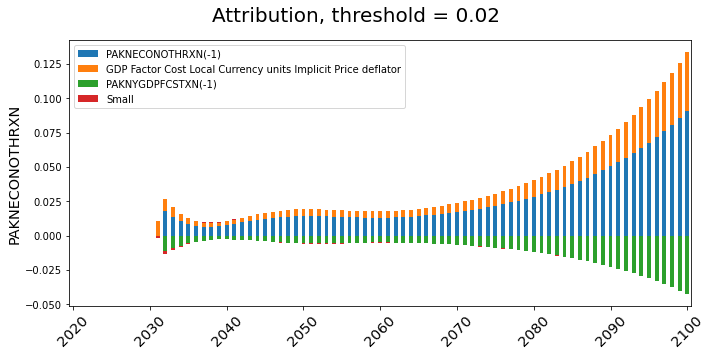

In [71]:
fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=False,rename=True,threshold=.02);

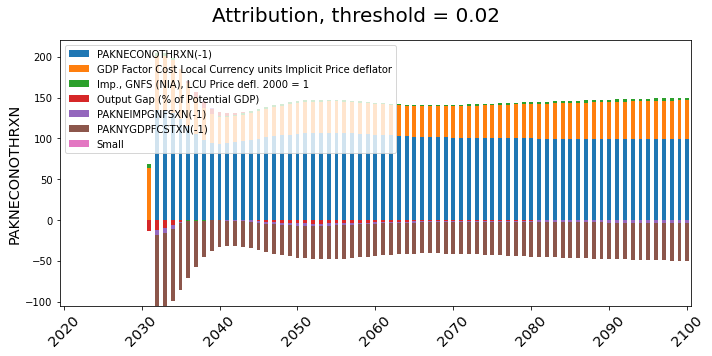

In [73]:
fig=mpak.dekomp_plot('PAKNECONOTHRXN',pct=True,rename=True,threshold=.02);

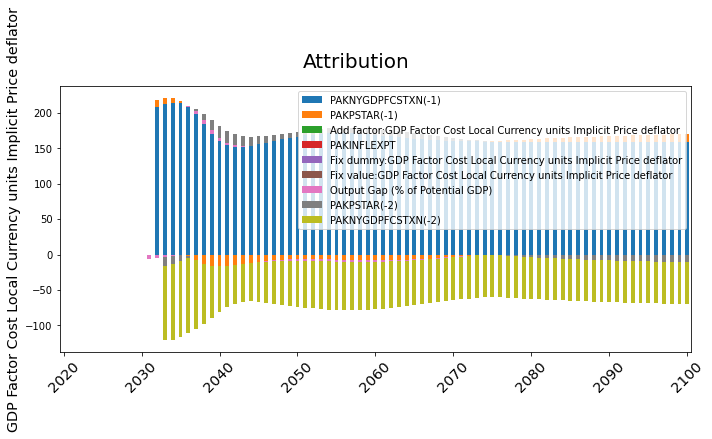

In [78]:
fig=mpak.dekomp_plot('PAKNYGDPFCSTXN',pct=True,rename=True,threshold=.00);

In [62]:
help(mpak.dekomp_plot)

Help on method dekomp_plot in module modelclass:

dekomp_plot(varnavn, sort=True, pct=True, per='', top=0.9, threshold=0.0, lag=True, rename=True, nametrans=<function Dekomp_Mixin.<lambda> at 0x000002093C157280>, time_att=False) method of modelclass.model instance
    Returns  a chart with attribution for a variable over the smpl  
    
    Parameters
    ----------
    varnavn : TYPE
        variable name.
    sort : TYPE, optional
        . The default is False.
    pct : TYPE, optional
        display pct contribution . The default is True.
    per : TYPE, optional
        DESCRIPTION. The default is ''.
    threshold : TYPE, optional
        cutoff. The default is 0.0.
    rename : TYPE, optional
        Use descriptions instead of variable names. The default is True.
    time_att : TYPE, optional
        Do time attribution . The default is False.
    lag : TYPE, optional
       separete by lags The default is True.           
    top : TYPE, optional
      where to place the titl


## .totdif() presents the impacts at the model level 

The method `.totdif()` returns an instance  the totdif class, which provides a number of methods and properties to explore the attribution at the model level.

It works by solving the model numerous time, each time changing one of the right hand side variables and calculating the impact on the dependent variable. By default it uses the values from the `.lastdf` Dataframe as the shock values and the values in `.basedf` as the initial values.

for the purpose of this exercise lets look at a simulation where monetary policy tightens raising the policy interest rate by 100 basis points for 3 years, and ten look at the impact on inflation.

To begin we reload the model.

In [ ]:
mpak,baseline = model.modelload('../../models/pak.pcim',alfa=0.7,run=1,keep='Business as Usual')


To determine the mnemonic for the monetary policy, search the dat dictionary for the word policy.

In [35]:
mpak['!*policy*'].des

PAKFMLBLPOLYXN        : Key Policy Interest Rate
PAKFMLBLPOLYXN_A      : Add factor:Key Policy Interest Rate
PAKFMLBLPOLYXN_D      : Fix dummy:Key Policy Interest Rate
PAKFMLBLPOLYXN_FITTED : Fitted  value:Key Policy Interest Rate
PAKFMLBLPOLYXN_X      : Fix value:Key Policy Interest Rate
PAKINTRDDIFF          : Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_A        : Add factor:Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_D        : Fix dummy:Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_FITTED   : Fitted  value:Domestic Interest Rate Spread Over Policy Rate
PAKINTRDDIFF_X        : Fix value:Domestic Interest Rate Spread Over Policy Rate
PAKINTREDIFF          : External Interest Rate Spread Over Policy Rate
PAKINTREDIFF_A        : Add factor:External Interest Rate Spread Over Policy Rate
PAKINTREDIFF_D        : Fix dummy:External Interest Rate Spread Over Policy Rate
PAKINTREDIFF_FITTED   : Fitted  value:External Interest Rate Spread Over Pol

The policy variable is `PAKFMLBLPOLYXN`, do a quick visualization to see its level (percentage points or perhaps ppt / 100?).

In [36]:
mpak['PAKFMLBLPOLYXN'].df

,PAKFMLBLPOLYXN
2020,7.106889
2021,7.549082
2022,7.797700
2023,7.865764
2024,7.804171
...,...
2096,9.661018
2097,9.666885
2098,9.672214
2099,9.677042


Create a new dataframe for the shocks scenario and increase the Policy rate by 1 percentage point during the period 2025-2027.

In [106]:
#MPShockdf=baseline.copy() #Create new df as copy of the baseline

import modelmf


MPShockdf=mpak.fix(mpak.basedf,'PAKPANUSATLS')
MPShockdf=MPShockdf.upd('<2025 2027> PAKFMLBLPOLYXN + 1')
MPShockdf=MPShockdf.mfcalc('PAKPANUSATLS_X = PAKPANUSATLS')

MPShockdf.loc[2023:2030,'PAKFMLBLPOLYXN']


2023    7.376232
2024    7.362666
2025    8.285334
2026    8.171706
2027    8.039316
2028    6.899970
2029    6.763110
2030    6.637192
Name: PAKFMLBLPOLYXN, dtype: float64

In [ ]:

mpak['*PAN*'].des

In [107]:
MPres = mpak(MPShockdf,2020,2100,keep='Increase Policy rate 1 ppt 2025-27') # simulates the model


C:\Users\wb268970\.conda\envs\modelflow\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


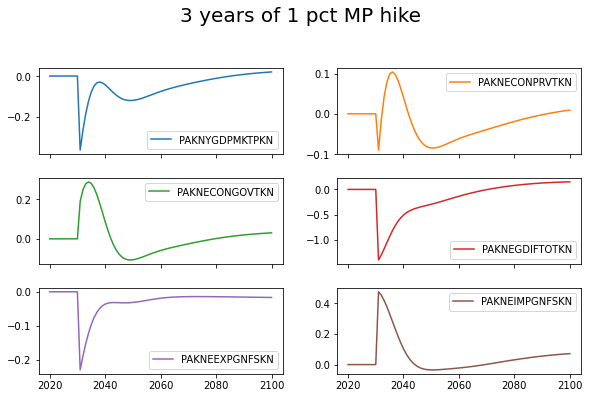

In [108]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEEXPGNFSKN PAKNEIMPGNFSKN'].difpctlevel.mul100.plot(title="3 years of 1 pct MP hike");

In [ ]:
mpak.set_smpl(2020,2040):
    mpak['PAKNEGDIFTOTKN PAKNYGDPMKTPKN'].difpctlevel.mul100.df;

In [80]:
totdekomp = mpak.totdif() # Calculate the total derivatives of all equations in the model.
showvar = 'PAKNYGDPMKTPKN'
totdekomp.explain_all('PAKNECONPRVTXN',kind='area',stacked=True,top=0.20);    

No variables to attribute to 


### .explain_all will visualize the results

In [79]:
showvar = 'PAKNYGDPMKTPKN PAKCCEMISCO2CKN PAKCCEMISCO2OKN PAKCCEMISCO2GKN PAKGGREVTOTLCN'
totdekomp.explain_all(showvar,kind='area',stacked=True,top=0.95);    


### Or we can use interactive widgets
This allows the user to select the specific variable of interest and what to display: 


:::{note}
If this is read in a manual the widget is not live. 

In a notebook the selection widgets are live. 
:::


In [5]:
display(mpak.get_att_gui(var='PAKGGREVTOTLCN',ysize=7));

interactive(children=(Dropdown(description='Variable', index=108, options=('CHNEXR05', 'CHNPCEXN05', 'DEUEXR05…

None

When the results are displayed, they can be filtered, sliced and diced in a number of ways. 

### More advanced model attribution

For some  models (like the EBA bank stress test model) the number of changed exogenous variables can be large. Using a dictionary to contain the experiments allows us to create experiments where all variables for each country are analyzed, or each macro variable for all countries are analyzed. 

Also it is possible to use aggregated sums - useful for looking at impact on PD's. Or just the last time period - useful for looking at CET1 ratios. 

If there are many experiments, data can be filtered in order to look only at the variables with an impact above a certain threshold. 

The is also the possibility to   anonymize  the row and column names and to randomize
the order of rows and/or columns - useful for bank names. 

### Single equation attribution chart 
The results can be visualized in different ways. 

In [7]:
help(mpak.dekomp_plot)

Help on method dekomp_plot in module modelclass:

dekomp_plot(varnavn, sort=True, pct=True, per='', top=0.9, threshold=0.0, lag=True, rename=True, nametrans=<function Dekomp_Mixin.<lambda> at 0x000002093C157280>, time_att=False) method of modelclass.model instance
    Returns  a chart with attribution for a variable over the smpl  
    
    Parameters
    ----------
    varnavn : TYPE
        variable name.
    sort : TYPE, optional
        . The default is False.
    pct : TYPE, optional
        display pct contribution . The default is True.
    per : TYPE, optional
        DESCRIPTION. The default is ''.
    threshold : TYPE, optional
        cutoff. The default is 0.0.
    rename : TYPE, optional
        Use descriptions instead of variable names. The default is True.
    time_att : TYPE, optional
        Do time attribution . The default is False.
    lag : TYPE, optional
       separete by lags The default is True.           
    top : TYPE, optional
      where to place the titl

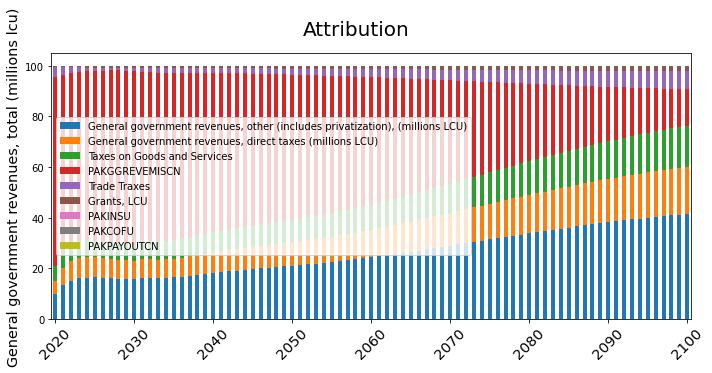

In [8]:
fig=mpak.dekomp_plot('PAKGGREVTOTLCN',pct=1);


### Chart in pct of the total 

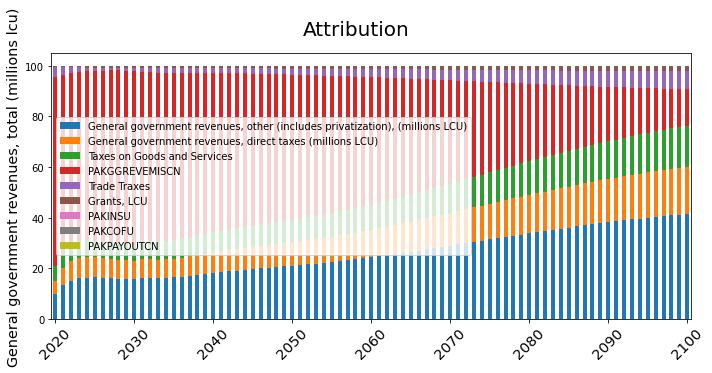

In [9]:
mpak.dekomp_plot('PAKGGREVTOTLCN',rename=1);

### Chart for one year 
The attribution for one year can be dispalyed in a waterfall chart. 

C:\Users\wb268970\.conda\envs\modelflow\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


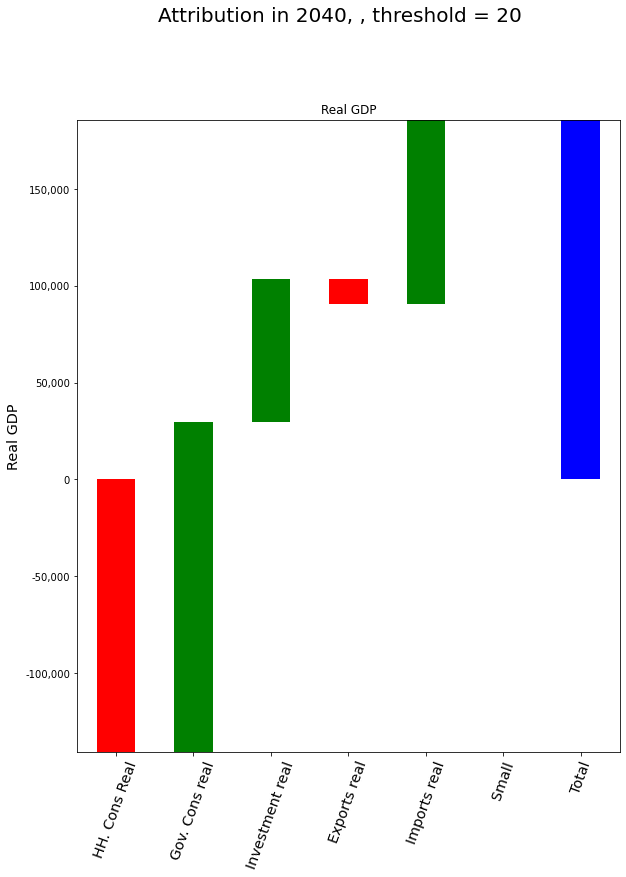

In [10]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,rename=1,pct=0,ysize=12,threshold =20);

### Sorting of attribution

C:\Users\wb268970\.conda\envs\modelflow\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


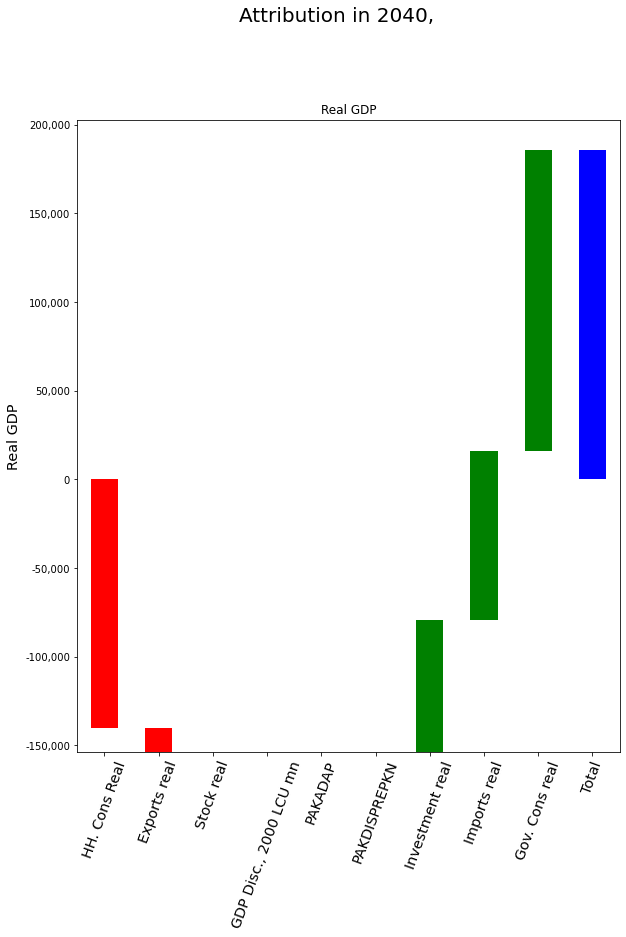

In [11]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,ysize=12);

### Truncate attribution
Some equations have a lot of small contributions. These can be aggregated through the ```threshold=<some number>``` parameter. 
Variables for which all contributions are below the threshold will be lumped together in the **small** bin. Like below:

C:\Users\wb268970\.conda\envs\modelflow\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


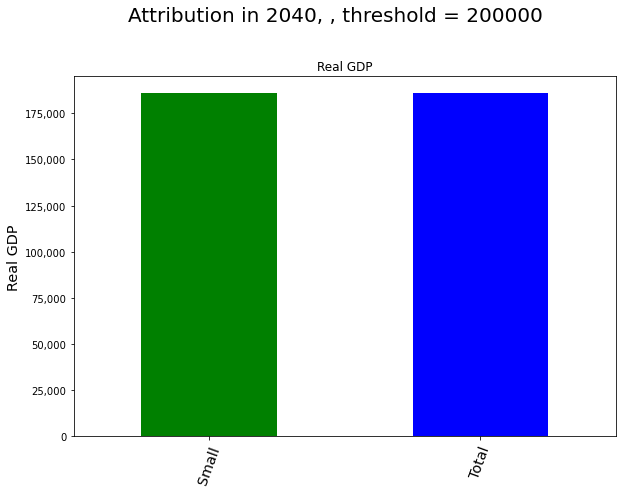

In [12]:
mpak.dekomp_plot_per('PAKNYGDPMKTPKN',per=2040,pct=0,rename=1,sort=1,threshold =200000,ysize=7);

### Attribution when comparing time frames 
In this case we seek to find out which variables explains the development from year to year. This is done only for the .lastdf dateframe. 

In [13]:
with mpak.set_smpl(2020,2024):
    mpak['PAKNYGDPMKTPKN'].dekomp(time_att=True)


Formula        : FRML <IDENT> PAKNYGDPMKTPKN = PAKNECONPRVTKN+PAKNECONGOVTKN+PAKNEGDIFTOTKN+PAKNEGDISTKBKN+PAKNEEXPGNFSKN-PAKNEIMPGNFSKN+PAKNYGDPDISCKN+PAKADAP*PAKDISPREPKN $ 

                      2020        2021        2022        2023        2024
Variable   lag                                                            
t-1        0   25760579.27 26470022.65 26764926.87 26889649.52 27089036.50
t          0   26470022.65 26764926.87 26889649.52 27089036.50 27454422.35
Difference 0     709443.38   294904.22   124722.65   199386.98   365385.85
Percent    0          2.75        1.11        0.47        0.74        1.35

 Contributions to differende for  PAKNYGDPMKTPKN
                         2020       2021       2022       2023       2024
Variable       lag                                                       
PAKNECONPRVTKN 0    421908.71  220215.41  108899.48  183642.23  333465.16
PAKNECONGOVTKN 0    344368.08   56568.07   -7860.16   16274.44   61873.41
PAKNEGDIFTOTKN 0    222358

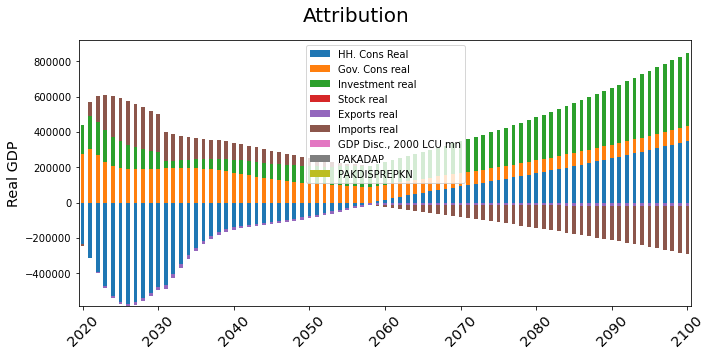

In [14]:
mpak.dekomp_plot('PAKNYGDPMKTPKN',pct=0,rename=1,sort=1,threshold =0,time_att = True);

### Visualizing attribution in dependency graphs
The logical graph of the model can be used to show the upstream and downstream variable for a specific variable. More on this [here](../structure/Logical_structure.ipynb)<br>
When drawing the logical graph for a variable the model attribution will be used to guide the thickness of edges between nodes (variables). This enables a visual impression of which 
variables drives the impact. 

::: {note}
If png == 0 the graph below will be rendered in SVG format. This enables tooltips with additional information when the mouse hovers 
over an edge or an node. 

Unfortunately svg can't be displayed in the manual, so png has to be True for the manual. In a live jupyter notebook set latex=0. This will 
enable svg format. 
:::

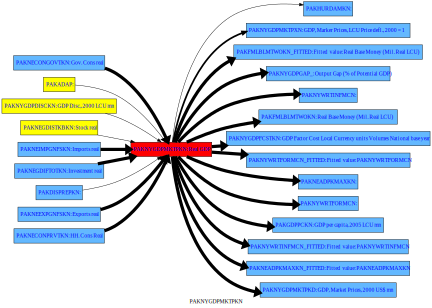

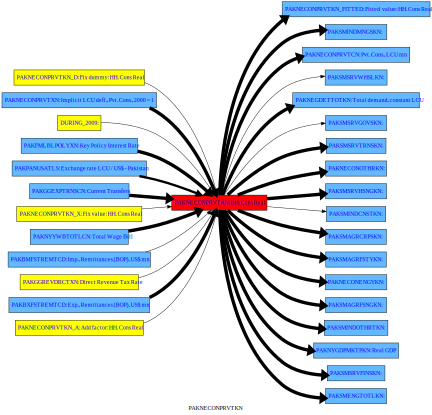

In [15]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN'].draw(up=1,down=1,png=latex)  # diagram all direct dependencies 

### The attribution can be filtered and more levels can be displayed. 

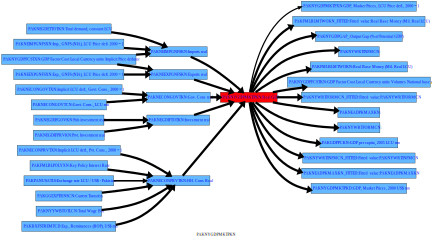

In [16]:
mpak['PAKNYGDPMKTPKN'].draw(up=2,down=1,png=latex,filter=20) 

### Or it can be used in a dashboard (not avaiable in the offline manual) 

In [17]:
try:
    mpak.modeldash('PAKNYGDPMKTPKN',jupyter=1,inline=False)
except: 
    print('No Dashboard installed')

No Dash
No Dash, name 'DashInteractiveGraphviz' is not defined
